In [ ]:
!pip install flwr==0.17.0
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%writefile cifar.py

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch import Tensor
from tqdm import tqdm
import numpy as np
import random
from typing import List, Tuple, Union, cast
import pickle

from flwr_experimental.baseline.dataset.dataset import create_partitioned_dataset, XY, XYList, shuffle, sort_by_label_repeating, split_at_fraction, shift, partition, combine_partitions, adjust_xy_shape,sort_by_label

import flwr as fl

class Net(nn.Module):
    """Simple CNN adapted from 'PyTorch: A 60 Minute Blitz'."""

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: Tensor) -> Tensor:
        """Compute forward pass."""
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_weights(self) -> fl.common.Weights:
        """Get model weights as a list of NumPy ndarrays."""
        return [val.cpu().numpy() for _, val in self.state_dict().items()]

    def set_weights(self, weights: fl.common.Weights) -> None:
        """Set model weights from a list of NumPy ndarrays."""
        state_dict = OrderedDict(
            {k: torch.Tensor(v) for k, v in zip(self.state_dict().keys(), weights)}
        )
        self.load_state_dict(state_dict, strict=True)


def load_model():
    return Net()


def load_data():
    """Loads CIFAR-10 (training and test set)."""
    data_root = "/content/data/cifar-10"
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = torchvision.datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform)
    return trainset, testset

class PartitionedDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (self.X[idx], int(self.Y[idx]))

def load_local_partitioned_data(client_id, num_partitions: int, iid_fraction: float, global_fraction: float, beta: float, alpha: float, classPerClient: int):
    """Creates a dataset for each worker, which is a partition of a larger dataset."""
    
    # Each worker loads the entire dataset, and then selects its partition
    # determined by its `client_id` (happens internally below)
    trainset, testset = load_data()
    [g_trainset, l_trainset] = torch.utils.data.random_split(trainset, [int(trainset.data.shape[0] * x) for x in [global_fraction,1-global_fraction]])
    [g_testset, l_testset] = torch.utils.data.random_split(testset, [int(testset.data.shape[0] * x) for x in [global_fraction,1-global_fraction]])
    
    if global_fraction!=0.0:
      # Process global data
      g_train_loader = DataLoader(g_trainset, batch_size=len(g_trainset))
      g_test_loader = DataLoader(g_testset, batch_size=len(g_testset))

      (g_x_train, g_y_train), (g_x_test, g_y_test) = next(iter(g_train_loader)), next(iter(g_test_loader))
      g_x_train, g_y_train = g_x_train.numpy(), g_y_train.numpy()
      g_x_test, g_y_test = g_x_test.numpy(), g_y_test.numpy()

      #global shared data must be iid
      g_iid_fraction = 1.0 

      (g_train_partitions, g_test_partitions), _ = create_partitioned_dataset(
          ((g_x_train, g_y_train), (g_x_test, g_y_test)), g_iid_fraction, num_partitions)
  
      g_x_train, g_y_train = g_train_partitions[client_id]
      
      g_x_test, g_y_test = g_test_partitions[client_id]

      # Process local data
      l_train_loader = DataLoader(l_trainset, batch_size=len(l_trainset))
      l_test_loader = DataLoader(l_testset, batch_size=len(l_testset))

      (l_x_train, l_y_train), (l_x_test, l_y_test) = next(iter(l_train_loader)), next(iter(l_test_loader))
      l_x_train, l_y_train = l_x_train.numpy(), l_y_train.numpy()
      l_x_test, l_y_test = l_x_test.numpy(), l_y_test.numpy()

      l_train_partitions=None
      l_test_partitions=None

      if classPerClient!=-1:
        (l_train_partitions, l_test_partitions), _ = create_partitioned_dataset_by_class(
            ((l_x_train, l_y_train), (l_x_test, l_y_test)), classPerClient, num_partitions)
      else:
        (l_train_partitions, l_test_partitions), _ = create_partitioned_dataset(
        ((l_x_train, l_y_train), (l_x_test, l_y_test)), iid_fraction, num_partitions)
    
      l_x_train, l_y_train = l_train_partitions[client_id]
      
      l_x_test, l_y_test = l_test_partitions[client_id]
      
      
        
      #Set beta
      g_train_len = int(len(l_x_train)*beta)
      [g_x_train, _] = torch.utils.data.random_split(g_x_train, [g_train_len, len(g_x_train)-g_train_len])
      [g_y_train, _] = torch.utils.data.random_split(g_y_train, [g_train_len, len(g_y_train)-g_train_len])
      g_torch_partition_trainset = PartitionedDataset(torch.Tensor(np.asarray(g_x_train)), g_y_train)


      g_test_len = int(len(l_x_test)*beta)
      [g_x_test, _] = torch.utils.data.random_split(g_x_test, [g_test_len, len(g_x_test)-g_test_len])
      [g_y_test, _] = torch.utils.data.random_split(g_y_test, [g_test_len, len(g_y_test)-g_test_len])
      g_torch_partition_testset = PartitionedDataset(torch.Tensor(np.asarray(g_x_test)), g_y_test )

      g_train_info = get_data_info(g_y_train)

      if alpha != 0.0:
        #Set alpha
        g_combined_train_len = int(len(g_x_train)*alpha)
        [g_x_train_combined, _] = torch.utils.data.random_split(g_x_train, [g_combined_train_len, len(g_x_train)-g_combined_train_len])
        [g_y_train_combined, _] = torch.utils.data.random_split(g_y_train, [g_combined_train_len, len(g_y_train)-g_combined_train_len])

        g_combined_test_len = int(len(g_x_test)*alpha)
        [g_x_test_combined, _] = torch.utils.data.random_split(g_x_test, [g_combined_test_len, len(g_x_test)-g_combined_test_len])
        [g_y_test_combined, _] = torch.utils.data.random_split(g_y_test, [g_combined_test_len, len(g_y_test)-g_combined_test_len])
        
        l_x_train = np.concatenate((g_x_train_combined, l_x_train))
        l_y_train = np.concatenate((g_y_train_combined, l_y_train))
        l_x_test = np.concatenate((g_x_test_combined, l_x_test))
        l_y_test = np.concatenate((g_y_test_combined, l_y_test))

      l_torch_partition_trainset = PartitionedDataset(torch.Tensor(np.asarray(l_x_train)), l_y_train)
      l_torch_partition_testset = PartitionedDataset(torch.Tensor(np.asarray(l_x_test)), l_y_test)
      l_train_info = get_data_info(l_y_train)
    else: #Process local data only
      l_train_loader = DataLoader(l_trainset, batch_size=len(l_trainset))
      l_test_loader = DataLoader(l_testset, batch_size=len(l_testset))

      (l_x_train, l_y_train), (l_x_test, l_y_test) = next(iter(l_train_loader)), next(iter(l_test_loader))
      l_x_train, l_y_train = l_x_train.numpy(), l_y_train.numpy()
      l_x_test, l_y_test = l_x_test.numpy(), l_y_test.numpy()

      l_train_partitions=None
      l_test_partitions=None
      
      if classPerClient!=-1:
        (l_train_partitions, l_test_partitions), _ = create_partitioned_dataset_by_class(
            ((l_x_train, l_y_train), (l_x_test, l_y_test)), classPerClient, num_partitions)
      else:
        (l_train_partitions, l_test_partitions), _ = create_partitioned_dataset(
        ((l_x_train, l_y_train), (l_x_test, l_y_test)), iid_fraction, num_partitions)
  
      l_x_train, l_y_train = l_train_partitions[client_id]
      l_x_test, l_y_test = l_test_partitions[client_id]

      l_torch_partition_trainset = PartitionedDataset(torch.Tensor(np.asarray(l_x_train)), l_y_train)
      l_torch_partition_testset = PartitionedDataset(torch.Tensor(np.asarray(l_x_test)), l_y_test)
      l_train_info = get_data_info(l_y_train)
      g_torch_partition_trainset=None
      g_torch_partition_testset=None
      g_train_info=None

    return g_torch_partition_trainset, g_torch_partition_testset, l_torch_partition_trainset, l_torch_partition_testset, g_train_info, l_train_info


def create_partitioned_dataset_by_class(keras_dataset: Tuple[XY, XY], classPerClient: int, num_partitions: int,) -> Tuple[PartitionedDataset, XY]:
    xy_train, xy_test = keras_dataset

    xy_train_partitions = create_partitions_by_class(
        unpartitioned_dataset=xy_train,
        classPerClient=classPerClient,
        num_partitions=num_partitions,
    )

    xy_test_partitions = create_partitions_by_class(
        unpartitioned_dataset=xy_test,
        classPerClient=classPerClient,
        num_partitions=num_partitions,
    )

    return (xy_train_partitions, xy_test_partitions), adjust_xy_shape(xy_test)

def create_partitions_by_class(unpartitioned_dataset: XY, classPerClient: int, num_partitions: int,) -> XYList: #10 clients
    """Create partitioned version of a training or test set.

    Currently tested and supported are MNIST, FashionMNIST and
    CIFAR-10/100
    """
    x, y = unpartitioned_dataset

    x, y = shuffle(x, y)
    x, y = sort_by_label(x, y)
    u, class_idx = np.unique(y, return_index=True)
    x_partitions = np.split(x,class_idx[1:])
    y_partitions = np.split(y,class_idx[1:])
    xy_partitions = None;
    if classPerClient==1:
      xy_partitions = list(zip(x_partitions, y_partitions))
    else:#classPerClient==2;
      two_class_x_partitions = []
      two_class_y_partitions = []
      for i in list(range(10)):
        [rand_1, rand_2] = random.sample(range(0, 10), 2)
        two_class_x_partitions.append(np.concatenate((x_partitions[rand_1],x_partitions[rand_2])))
        two_class_y_partitions.append(np.concatenate((y_partitions[rand_1],y_partitions[rand_2])))
      xy_partitions = list(zip(two_class_x_partitions, two_class_y_partitions))

    # Adjust x and y shape
    return [adjust_xy_shape(xy) for xy in xy_partitions]

# def load_local_partitioned_data(client_id, iid_fraction: float, num_partitions: int, global_fraction: float, beta: float, alpha: float):
#     """Creates a dataset for each worker, which is a partition of a larger dataset."""
    
#     # Each worker loads the entire dataset, and then selects its partition
#     # determined by its `client_id` (happens internally below)
#     trainset, testset = load_data()

#     [g_trainset, l_trainset] = torch.utils.data.random_split(trainset, [int(trainset.data.shape[0] * x) for x in [global_fraction,1-global_fraction]])
#     [g_testset, l_testset] = torch.utils.data.random_split(testset, [int(testset.data.shape[0] * x) for x in [global_fraction,1-global_fraction]])
    
#     # Process global data
#     g_train_loader = DataLoader(g_trainset, batch_size=len(g_trainset))
#     g_test_loader = DataLoader(g_testset, batch_size=len(g_testset))

#     (g_x_train, g_y_train), (g_x_test, g_y_test) = next(iter(g_train_loader)), next(iter(g_test_loader))
#     g_x_train, g_y_train = g_x_train.numpy(), g_y_train.numpy()
#     g_x_test, g_y_test = g_x_test.numpy(), g_y_test.numpy()

#     #global shared data must be iid
#     g_iid_fraction = 1.0 

#     (g_train_partitions, g_test_partitions), _ = create_partitioned_dataset(
#         ((g_x_train, g_y_train), (g_x_test, g_y_test)), g_iid_fraction, num_partitions)
 
#     g_x_train, g_y_train = g_train_partitions[client_id]
    
#     g_x_test, g_y_test = g_test_partitions[client_id]

#     # Process local data
#     l_train_loader = DataLoader(l_trainset, batch_size=len(l_trainset))
#     l_test_loader = DataLoader(l_testset, batch_size=len(l_testset))

#     (l_x_train, l_y_train), (l_x_test, l_y_test) = next(iter(l_train_loader)), next(iter(l_test_loader))
#     l_x_train, l_y_train = l_x_train.numpy(), l_y_train.numpy()
#     l_x_test, l_y_test = l_x_test.numpy(), l_y_test.numpy()

#     (l_train_partitions, l_test_partitions), _ = create_partitioned_dataset(
#         ((l_x_train, l_y_train), (l_x_test, l_y_test)), iid_fraction, num_partitions)
 
#     l_x_train, l_y_train = l_train_partitions[client_id]
    
#     l_x_test, l_y_test = l_test_partitions[client_id]
    

#     #Set beta
#     g_train_len = int(len(l_x_train)*beta)
#     [g_x_train, _] = torch.utils.data.random_split(g_x_train, [g_train_len, len(g_x_train)-g_train_len])
#     [g_y_train, _] = torch.utils.data.random_split(g_y_train, [g_train_len, len(g_y_train)-g_train_len])
#     g_torch_partition_trainset = PartitionedDataset(torch.Tensor(np.asarray(g_x_train)), g_y_train)


#     g_test_len = int(len(l_x_test)*beta)
#     [g_x_test, _] = torch.utils.data.random_split(g_x_test, [g_test_len, len(g_x_test)-g_test_len])
#     [g_y_test, _] = torch.utils.data.random_split(g_y_test, [g_test_len, len(g_y_test)-g_test_len])
#     g_torch_partition_testset = PartitionedDataset(torch.Tensor(np.asarray(g_x_test)), g_y_test )

#     g_train_info = get_data_info(g_y_train)

#     #Set alpha
#     if alpha != 0.0:
#       g_combined_train_len = int(len(g_x_train)*alpha)
#       [g_x_train_combined, _] = torch.utils.data.random_split(g_x_train, [g_combined_train_len, len(g_x_train)-g_combined_train_len])
#       [g_y_train_combined, _] = torch.utils.data.random_split(g_y_train, [g_combined_train_len, len(g_y_train)-g_combined_train_len])

#       g_combined_test_len = int(len(g_x_test)*alpha)
#       [g_x_test_combined, _] = torch.utils.data.random_split(g_x_test, [g_combined_test_len, len(g_x_test)-g_combined_test_len])
#       [g_y_test_combined, _] = torch.utils.data.random_split(g_y_test, [g_combined_test_len, len(g_y_test)-g_combined_test_len])

#       l_x_train = np.concatenate((g_x_train_combined, l_x_train))
#       l_y_train = np.concatenate((g_y_train_combined, l_y_train))
#       l_x_test = np.concatenate((g_x_test_combined, l_x_test))
#       l_y_test = np.concatenate((g_y_test_combined, l_y_test))

#     l_torch_partition_trainset = PartitionedDataset(torch.Tensor(np.asarray(l_x_train)), l_y_train)
#     l_torch_partition_testset = PartitionedDataset(torch.Tensor(np.asarray(l_x_test)), l_y_test)
#     l_train_info = get_data_info(l_y_train)

#     return g_torch_partition_trainset, g_torch_partition_testset, l_torch_partition_trainset, l_torch_partition_testset, g_train_info, l_train_info


def get_data_info(y):
    #total amount of data
    length = len(y)
    #Class - Sample dictionary
    (unique, counts) = np.unique(y, return_counts=True)
    return (length, dict(zip(unique, counts)))


# def get_partitionedDataset(train_partitions, test_partitions, global_partition, client_id):
#       [x_train, y_train] = train_partitions[client_id]
#       torch_partition_trainset = PartitionedDataset(torch.Tensor(x_train), y_train)
#       x_test, y_test = test_partitions[client_id]
#       torch_partition_testset = PartitionedDataset(torch.Tensor(x_test), y_test)
#       global_x_train, global_y_train = global_partition[client_id]
#       torch_partition_global_trainset = PartitionedDataset(torch.Tensor(global_x_train), global_y_train)
#       return torch_partition_trainset, torch_partition_testset, torch_partition_global_trainset


def train(
    net: Net,
    trainloader: torch.utils.data.DataLoader,
    device: torch.device,
    start_epoch: int,
    end_epoch: int,
    log_progress: bool = True):
    """Trains a network on provided data from `start_epoch` to `end_epoch` incl. (the training loop)."""

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    print(f"Training from epoch(s) {start_epoch} to {end_epoch} w/ {len(trainloader)} batches each.", flush=True)
    results = []

    # Train the network
    for epoch in range(start_epoch, end_epoch+1):  # loop over the dataset multiple times, last epoch inclusive
        total_loss, total_correct, n_samples = 0.0, 0.0, 0
        pbar = tqdm(trainloader, desc=f'TRAIN Epoch {epoch}') if log_progress else trainloader
        for data in pbar:
            images, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Collected training loss and accuracy statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) 
            n_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

            if log_progress:
                pbar.set_postfix({
                    "train_loss": total_loss/n_samples, 
                    "train_acc": total_correct/n_samples
                })
            
        results.append((total_loss/n_samples, total_correct/n_samples))    
        
    return results      
    
def test(
    net: Net,
    testloader: torch.utils.data.DataLoader,
    device: torch.device,
    log_progress: bool = True):
    """Evaluates the network on test data."""
    criterion = nn.CrossEntropyLoss()
    total_loss, total_correct, n_samples = 0.0, 0.0, 0
    with torch.no_grad():
        pbar = tqdm(testloader, desc="TEST") if log_progress else testloader
        for data in pbar:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)

            # Collected testing loss and accuracy statistics
            total_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1) 
            n_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item() 
    
    return (total_loss/n_samples, total_correct/n_samples)


Overwriting cifar.py


In [ ]:
%%writefile client.py
import argparse
import grpc
import timeit
import torch
import torchvision
import flwr as fl
import random

from collections import OrderedDict
from typing import Optional
from torch.utils.data import DataLoader
from flwr.common import EvaluateIns, EvaluateRes, FitIns, FitRes, ParametersRes, Weights
import time


import cifar

DEFAULT_SERVER_ADDRESS = "localhost:8099"
DEVICE = torch.device("cpu")

class CifarClient(fl.client.Client):
    """Flower client implementing CIFAR-10 image classification using PyTorch."""
    def __init__(
        self, cid,
        model: cifar.Net,
        trainset: torchvision.datasets.CIFAR10,
        testset: torchvision.datasets.CIFAR10,
        exp_name: Optional[str],
        iid_fraction: Optional[float]):
        self.cid = cid
        self.model = model
        self.trainset = trainset
        self.testset = testset
        self.exp_name = exp_name or 'federated_unspecified'
        print(f"Client {self.cid} running experiment {self.exp_name}")


    def get_parameters(self) -> ParametersRes:
        print(f"Client {self.cid}: get_parameters")

        weights: Weights = self.model.get_weights()
        parameters = fl.common.weights_to_parameters(weights)
        return ParametersRes(parameters=parameters)

    def fit(self, ins: FitIns) -> FitRes:
        print(f"Client {self.cid}: fit")
        config = ins.config
        weights: Weights = fl.common.parameters_to_weights(ins.parameters)

        # Get training config
        epochs = int(config["epochs"])
        batch_size = int(config["batch_size"])
        epoch_global = int(config["epoch_global"])

        # Set model parameters
        self.model.set_weights(weights)

        # Train the model
        trainloader = DataLoader(self.trainset, batch_size=batch_size, shuffle=True)
        
        start_epoch = epoch_global + 1
        end_epoch = start_epoch + epochs - 1

        fit_begin = timeit.default_timer()
        training_log = cifar.train(net=self.model, trainloader=trainloader, device=DEVICE, 
                                   start_epoch=start_epoch, end_epoch=end_epoch, log_progress=False)
        fit_duration = timeit.default_timer() - fit_begin

        train_loss, train_acc = training_log[-1]
        print(f'Client {self.cid}: train_loss={train_loss:.4f}, train_accuracy={train_acc:.4f}')

        # Return the refined weights and the number of examples used for training
        weights_prime: Weights = self.model.get_weights()
        params_prime = fl.common.weights_to_parameters(weights_prime)
        num_examples_train = len(self.trainset)
        return FitRes(
            parameters=params_prime,
            num_examples=num_examples_train,
            num_examples_ceil=num_examples_train,
            fit_duration=fit_duration,
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        print(f"Client {self.cid}: evaluate")
        config = ins.config
        epoch_global = int(config["epoch_global"])
        
        # Use provided weights to update the local model
        weights = fl.common.parameters_to_weights(ins.parameters)
        self.model.set_weights(weights)

        # Evaluate the updated model on the local dataset
        testloader = DataLoader(self.testset, batch_size=32, shuffle=False)
        test_loss, test_acc = cifar.test(net=self.model, testloader=testloader, 
                                         device=DEVICE, log_progress=False)
        print(f"Client {self.cid}: test_loss={test_loss:.4f}, test_accuracy={test_acc:.4f}")

        # Return the number of evaluation examples and the evaluation result (loss)
        return EvaluateRes(
            num_examples=len(self.testset), loss=test_loss, accuracy=test_acc
        )

def start_client(client_id, num_partitions, iid_fraction=1.0, gtol=0.2, beta=0.25,alpha=0.5,classPerClient=-1,
                 server_address=DEFAULT_SERVER_ADDRESS, log_host=None, exp_name=None):


    # Configure logger
    fl.common.logger.configure(f"client_{client_id}", host=log_host)

    # Load model and data
    print(f"Loading data for client {client_id}")

    g_trainset, g_testset, l_trainset, l_testset, g_info, l_info = cifar.load_local_partitioned_data(
        client_id=client_id, 
        num_partitions=num_partitions,
        iid_fraction=iid_fraction,
        global_fraction=gtol,
        beta=beta,
        alpha=alpha,
        classPerClient=classPerClient)
    
    model = cifar.load_model()
    model.to(DEVICE)

    if gtol!=0.0:
      # Start global model training
      print(f"Start Global traning on Client {client_id}; Global training set size {g_info[0]}; Global training set distribution {str(g_info[1])}")
      globalloader = DataLoader(g_trainset, batch_size=32, shuffle=True)
      cifar.train(model,globalloader,DEVICE,0,10,log_progress=False)

      testloader = DataLoader(g_testset, batch_size=32, shuffle=True)
      loss,acc = cifar.test(model,testloader,DEVICE,log_progress=False)
      print(f"Global traning accuracy: {acc} on Client {client_id}")

    # Start client
    print(f"Starting client {client_id}; Local training set size {l_info[0]}; Local training set distribution {str(l_info[1])}")
    client = CifarClient(client_id, model, l_trainset, l_testset, 
        f'{exp_name}_iid-fraction_{iid_fraction}', iid_fraction)

    print(f"Connecting to {server_address}")

    try:
        # There's no graceful shutdown when gRPC server terminates, so we try/except
        fl.client.start_client(server_address, client)
    except grpc._channel._MultiThreadedRendezvous:
        print(f"Client {client_id}: shutdown")

def main():
    parser = argparse.ArgumentParser(description="Flower client")
    parser.add_argument("--server_address", type=str, default=DEFAULT_SERVER_ADDRESS,
        help=f"gRPC server address (default: {DEFAULT_SERVER_ADDRESS})")
    parser.add_argument("--cid", type=int, required=True, help="Client CID (no default)")
    parser.add_argument("--num_partitions", type=int, required=True, 
        help="Total number of clients participating in training")
    parser.add_argument("--iid_fraction", type=float, nargs="?", const=1.0, 
        help="Fraction of data [0,1] that is independent and identically distributed.")
    parser.add_argument("--gtol", type=float, required=True, 
        help="Total number of clients participating in training")
    parser.add_argument("--beta", type=float, required=True, 
        help="Total number of clients participating in training")
    parser.add_argument("--alpha", type=float, required=True, 
        help="Total number of clients participating in training")
    parser.add_argument("--log_host", type=str, help="Log server address")
    parser.add_argument("--exp_name", type=str, help="Friendly experiment name")
    parser.add_argument("--classPerClient", type=int, help="Friendly experiment name")

    args, _ = parser.parse_known_args()
    start_client(client_id=args.cid,
                 num_partitions=args.num_partitions,
                 iid_fraction=float(args.iid_fraction),
                 log_host=args.log_host,
                 server_address=args.server_address,
                 exp_name=args.exp_name,
                 gtol=float(args.gtol),
                 beta=float(args.beta),
                 alpha=float(args.alpha),
                 classPerClient=int(args.classPerClient))

if __name__=="__main__":
    main()


    

Overwriting client.py


In [ ]:
%%writefile server.py

import argparse
from typing import Callable, Dict, Optional, Tuple

from logging import INFO
from flwr.common.logger import log
from flwr.server.grpc_server.grpc_server import start_insecure_grpc_server

import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter

import flwr as fl
import cifar
import pickle

DEFAULT_SERVER_ADDRESS = "localhost:8099"

DEVICE = torch.device("cpu")


def start_server(exp_name=None, 
                 server_address=DEFAULT_SERVER_ADDRESS, 
                 rounds=1,
                 epochs=10,
                 batch_size=32,
                 sample_fraction=1.0,
                 min_sample_size=2,
                 min_num_clients=2,
                 log_host=None):

    if not exp_name:
        exp_name = f"federated_rounds_{rounds}_" \
                   f"epochs_{epochs}_" \
                   f"min_num_clients_{min_num_clients}_" \
                   f"min_sample_size_{min_sample_size}_" \
                   f"sample_fraction_{sample_fraction}"

    # Configure logger
    fl.common.logger.configure("server", host=log_host)

    # Load evaluation data
    _, testset = cifar.load_data()
    
    # Create client_manager, strategy, and server
    client_manager = fl.server.SimpleClientManager()

    strategy = fl.server.strategy.FedAvg(
        fraction_fit=sample_fraction,
        min_fit_clients=min_sample_size,
        min_eval_clients=min_sample_size,
        min_available_clients=min_num_clients,
        eval_fn=get_eval_fn(testset),
        on_fit_config_fn=generate_config(epochs, batch_size),
        on_evaluate_config_fn=generate_config(epochs, batch_size)
    )
    server = fl.server.Server(client_manager=client_manager, strategy=strategy)

    # Run server 
    print(f"Starting gRPC server on {server_address}...")
    grpc_server = start_insecure_grpc_server(
        client_manager=server.client_manager(),
        server_address=server_address,
        max_message_length=fl.common.GRPC_MAX_MESSAGE_LENGTH,
    )
    
    # Fit model
    print("Fitting the model...")
    hist = server.fit(num_rounds=rounds)
 
    log(INFO, f"app_fit: losses_centralized={hist.losses_centralized}")
    log(INFO, f"app_fit: accuracies_centralized={hist.metrics_centralized['accuracy']}")

    # Evaluate the final accuracy on the server
    test_loss, test_metrics = server.strategy.evaluate(parameters=server.parameters)
    print(f"Server-side test results after training: test_loss={test_loss:.4f}, "
          f"test_accuracy={test_metrics['accuracy']:.4f}")
    with open(f'logs/{exp_name}.txt', 'wb') as fp:
      pickle.dump([hist.losses_centralized, hist.metrics_centralized['accuracy']], fp)
    # Now, apply temporary workaround to force distributed evaluation
    server.strategy.eval_fn = None

    # Stop the gRPC server
    grpc_server.stop(None)    


def generate_config(epochs, batch_size):
    def fit_config(round: int) -> Dict[str, str]:
        print(f"Configuring round {round}...")
        return {
            "epoch_global": str((round - 1) * epochs),
            "epochs": str(epochs),
            "batch_size": str(batch_size),
        }
    
    return fit_config 


def get_eval_fn(testset: torchvision.datasets.CIFAR10):
    """Returns an evaluation function for centralized (server-side) evaluation."""
    def evaluate(weights: fl.common.Weights):
        """Use the entire CIFAR-10 test set for evaluation."""
        model = cifar.load_model()
        model.set_weights(weights)
        model.to(DEVICE)
        testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
        loss, accuracy = cifar.test(net=model, testloader=testloader, device=DEVICE, log_progress=False)
        return loss, {"accuracy": accuracy}

    return evaluate


def main():
    parser = argparse.ArgumentParser(description="Flower server")
    parser.add_argument("--server_address", type=str, default=DEFAULT_SERVER_ADDRESS,
        help=f"gRPC server address (default: {DEFAULT_SERVER_ADDRESS})")
    parser.add_argument("--rounds", type=int, default=1,
        help="Number of rounds of federated learning (default: 1)")
    parser.add_argument("--sample_fraction", type=float, default=1.0,
        help="Fraction of available clients used for fit/evaluate (default: 1.0)")
    parser.add_argument("--min_sample_size", type=int, default=2,
        help="Minimum number of clients used for fit/evaluate (default: 2)")
    parser.add_argument("--min_num_clients", type=int, default=2,
        help="Minimum number of available clients needed for sampling (default: 2)")
    parser.add_argument("--log_host", type=str, help="Log server address (no default)")
    parser.add_argument("--epochs", type=int, default=10,
        help="Number of epochs each client will train for (default: 10)")
    parser.add_argument("--batch_size", type=int, default=32,
        help="Number of samples per batch each client will use (default: 32)")   
    parser.add_argument("--exp_name", type=str,
        help="Name of the experiment you are running (no default)")
    args, _ = parser.parse_known_args()
    
    start_server(exp_name=args.exp_name,
                 server_address=args.server_address,
                 rounds=args.rounds,
                 epochs=args.epochs,
                 batch_size=args.batch_size,
                 sample_fraction=args.sample_fraction,
                 min_sample_size=args.min_sample_size,
                 min_num_clients=args.min_num_clients,
                 log_host=args.log_host)

if __name__ == "__main__":
    main()

Overwriting server.py


In [ ]:
%cd drive/MyDrive/Colab Notebooks/
!ls

/content/drive/MyDrive/Colab Notebooks
 cifar.py
 client.py
 clients.sh
'Copy of 02-02-simulation (1).ipynb'
'Copy of 02-02-simulation.ipynb'
'Copy of 2021 L46 Practical 1: Keyword spotting model'
'Copy of 2021 L46 Practical 2: GPU Training'
'Copy of 2021 L46 Practical 3: Federated Learning'
'Copy of Dataflow programming using TensorFlow Student  Copy.ipynb'
'cyp25 2021 L46 Practical 1: Keyword spotting model'
 logs
 Non-iid_0.25.ipynb
 Non-iid_0.5.ipynb
 Non-iid_0.75.ipynb
 Non-iid_1_class.ipynb
 Non-iid_1.ipynb
 Non-iid_2_class.ipynb
 __pycache__
 server.py
 server.sh
 sunspot.ipynb
 Untitled
 Untitled0.ipynb
 Untitled1.ipynb
 Untitled2.ipynb


In [ ]:
%%writefile server.sh
export PYTHONUNBUFFERED=1

#noniid, GlobalToLocalRatio, Beta, Alpha, classPerClient
# exp='1.0;0.2;0.25;0.5;-1'
# exp='0.75;0.2;0.25;0.5;-1'
# exp='0.5;0.2;0.25;0.5;-1'
# exp='0.25;0.2;0.25;0.5;-1'
# exp='1.0;0.2;0.25;0.5;1'
exp='1.0;0.2;0.25;0.5;2'

server_address='localhost:24339'
python3 server.py \
    --rounds=3 \
    --epochs=10 \
    --sample_fraction=1 \
    --min_sample_size=5 \
    --min_num_clients=5 \
    --server_address=$server_address\
    --exp_name=$exp


Overwriting server.sh


In [ ]:
%%writefile clients.sh
export PYTHONUNBUFFERED=1
NUM_CLIENTS=10

#noniid, GlobalToLocalRatio, Beta, Alpha, classPerClient
# exp='1.0;0.2;0.25;0.5;-1'
# exp='0.75;0.2;0.25;0.5;-1'
# exp='0.5;0.2;0.25;0.5;-1'
# exp='0.25;0.2;0.25;0.5;-1'
# exp='1.0;0.2;0.25;0.5;1'
exp='1.0;0.2;0.25;0.5;2'

server_address='localhost:24339'
IFS=";" read -r -a arr <<< "${exp}"
noniid="${arr[0]}"
gtol="${arr[1]}"
beta="${arr[2]}"
alpha="${arr[3]}"
classPerClient="${arr[4]}"

for ((i = 0; i < $NUM_CLIENTS; i++))
do
    echo "Starting client(cid=$i) with partition $i out of $NUM_CLIENTS clients."
    sleep 8s  
    python3 client.py \
      --cid=$i \
      --num_partitions=${NUM_CLIENTS} \
      --iid_fraction=$noniid \
      --gtol=$gtol\
      --beta=$beta\
      --alpha=$alpha\
      --server_address=$server_address\
      --classPerClient=$classPerClient\
      --exp_name="federated_${NUM_CLIENTS}_clients" &
done
 

Overwriting clients.sh


In [ ]:
!chmod +x clients.sh server.sh

In [ ]:
%killbgscripts
!((./server.sh & sleep 5s); ./clients.sh)

All background processes were killed.
Files already downloaded and verified
Starting client(cid=0) with partition 0 out of 10 clients.
Files already downloaded and verified
Starting gRPC server on localhost:24339...
Fitting the model...
INFO flower 2022-01-09 19:39:53,323 | server.py:118 | Initializing global parameters
INFO flower 2022-01-09 19:39:53,323 | server.py:304 | Requesting initial parameters from one random client
Starting client(cid=1) with partition 1 out of 10 clients.
Loading data for client 0
Files already downloaded and verified
Files already downloaded and verified
Starting client(cid=2) with partition 2 out of 10 clients.
Loading data for client 1
Files already downloaded and verified
Files already downloaded and verified
Starting client(cid=3) with partition 3 out of 10 clients.
Loading data for client 2
Files already downloaded and verified
Files already downloaded and verified
Starting client(cid=4) with partition 4 out of 10 clients.
Loading data for client 3
Fil

In [ ]:
#Experiment
#Global Local Ratio 0.2, Beta=0.25 Alpha=0.5 (Experiment IID)
  # noniid-1.0-gtolratio-0.2-beta-0.25-alpha-0.5
  #iid=1.0, 0.75, 0.5, 0.25, 1class, 2class
#Global Local Ratio 0.2, iid=2class Alpha=0.5 (Experiment Beta)
  #Beta=0.25, 0.2, 0.15, 0.1 
#Global Local Ratio 0.2, iid=2class Beta=0.25 (Experiemnt Alpha)
  #Alpha=1,0.8,0.5,0.2,0.1
#iid=2class Beta=0.25 Alpha=0.5
  #exp='1.0;0.3;0.25;0.5;2'
  #global=0.3,0.2,0.1,0.05

In [ ]:
# iid_fraction 1.0
losses_centralized_iid_1 =[(0, 0.07220932688713073), (1, 0.06973186511993408), (2, 0.058325643408298496), (3, 0.051442525255680084)]
accuracies_centralized_iid_1 =[(0, 0.1), (1, 0.2159), (2, 0.3299), (3, 0.408)]

# iid_fraction 0.75
losses_centralized_iid_75=[(0, 0.07207719354629516), (1, 0.06536008388996124), (2, 0.055578639769554135), (3, 0.05072008833885193)]
accuracies_centralized_iid_75 =[(0, 0.0999), (1, 0.2173), (2, 0.3585), (3, 0.4225)]

# iid_fraction 0.5
losses_centralized_iid_5 =[(0, 0.07239096665382386), (1, 0.0669349681377411), (2, 0.054201741981506346), (3, 0.04927621845006943)]
accuracies_centralized_iid_5 =[(0, 0.1), (1, 0.2248), (2, 0.3752), (3, 0.4347)]

# iid_fraction 0.25
losses_centralized_iid_25 =[(0, 0.07210694007873535), (1, 0.06778777270317078), (2, 0.05507556644678116), (3, 0.05044988602399826)]
accuracies_centralized_iid_25 =[(0, 0.0996), (1, 0.2251), (2, 0.36), (3, 0.4165)]

# iid 1 class
losses_centralized_iid_1_class =[(0, 0.07219128305912018), (1, 0.07358644070625305), (2, 0.07208134472370148), (3, 0.07188054387569427)]
accuracies_centralized_iid_1_class =[(0, 0.1), (1, 0.1038), (2, 0.1065), (3, 0.1128)]

# iid 2 class
losses_centralized_iid_2_class=[(0, 0.07226183662414551), (1, 0.07617147347927093), (2, 0.06890336064100265), (3, 0.06537702754735947)]
accuracies_centralized_iid_2_class=[(0, 0.0993), (1, 0.141), (2, 0.1783), (3, 0.2118)]

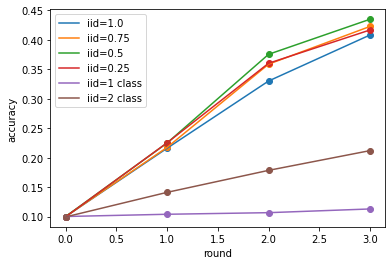

In [ ]:
import matplotlib.pyplot as plt
def turn_to_list(ls):
  return [t[1] for t in ls]

rounds = list(range(4))

plt.scatter(rounds,turn_to_list(accuracies_centralized_iid_1))
plt.scatter(rounds,turn_to_list(accuracies_centralized_iid_75))
plt.scatter(rounds,turn_to_list(accuracies_centralized_iid_5))
plt.scatter(rounds,turn_to_list(accuracies_centralized_iid_25))
plt.scatter(rounds,turn_to_list(accuracies_centralized_iid_1_class))
plt.scatter(rounds,turn_to_list(accuracies_centralized_iid_2_class))

plt.plot(rounds, turn_to_list(accuracies_centralized_iid_1), label="iid=1.0")
plt.plot(rounds, turn_to_list(accuracies_centralized_iid_75), label="iid=0.75")
plt.plot(rounds, turn_to_list(accuracies_centralized_iid_5), label="iid=0.5")
plt.plot(rounds, turn_to_list(accuracies_centralized_iid_25), label="iid=0.25")
plt.plot(rounds, turn_to_list(accuracies_centralized_iid_1_class), label="iid=1 class")
plt.plot(rounds, turn_to_list(accuracies_centralized_iid_2_class), label="iid=2 class")
plt.xlabel("round")
plt.ylabel("accuracy")
plt.legend(loc="upper left")
plt.show()



In [ ]:
import pickle
import numpy as np

with open(f'logs/1.0;0.2;0.25;0.5;1.txt', 'rb') as fp:
  results = np.asarray(pickle.load(fp))
  print(results)

[[[0.         0.07220737]
  [1.         0.07326955]
  [2.         0.07196945]
  [3.         0.07166226]]

 [[0.         0.1       ]
  [1.         0.1       ]
  [2.         0.0988    ]
  [3.         0.1308    ]]]
